In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

df = pd.read_csv("D://Gitrepo//Blog//rus2.csv", sep=",")

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [7]:
dt = df.select_dtypes(include=np.number)
clean_dataset(dt)
dt.head(6)


,total_time,wait_time,surge_multiplier,driver_gender,price_usd,distance_kms,temperature_value,humidity,wind_speed
0,29,7,1.0,1,5.17,9.29,12,0.69,4.81
1,26,6,1.0,1,4.97,9.93,10,0.70,6.53
2,83,16,1.0,1,13.01,18.01,14,0.61,5.25
3,20,6,2.9,1,25.99,5.10,3,0.84,0.87
4,49,10,1.4,1,13.43,21.92,3,0.90,1.61
5,34,17,1.0,1,4.06,4.88,7,0.83,2.73


In [8]:
df[df["ride_hailing_app"] == "Uber"].shape
df[df["ride_hailing_app"] == "Gett"].shape

print(
    "Uber size: ",
    df[df["ride_hailing_app"] == "Uber"].shape,
    "\n Gett size: ",
    df[df["ride_hailing_app"] == "Gett"].shape,
)

Uber size:  (642, 19) 
 Gett size:  (36, 19)


In [10]:
y = dt["price_usd"].values
x = dt.drop(["price_usd"], axis=1)



In [11]:
pca = PCA()
X_reduced = pca.fit_transform(scale(x))
pd.DataFrame(pca.components_.T).loc[:5, :5]


,0,1,2,3,4,5
0,0.692667,-0.112583,-0.039522,-0.025766,0.019017,-0.047957
1,0.500662,-0.041094,-0.479095,0.124474,0.329412,0.376474
2,0.008190,-0.082623,0.372405,0.675290,0.564377,-0.279762
3,-0.006483,-0.118291,0.496058,-0.566484,0.523330,0.371541
4,0.492186,-0.090315,0.469016,-0.155549,-0.343554,-0.375643
5,0.148509,0.652022,0.159145,0.131533,-0.059497,0.124116


(-1.0, 19.95)

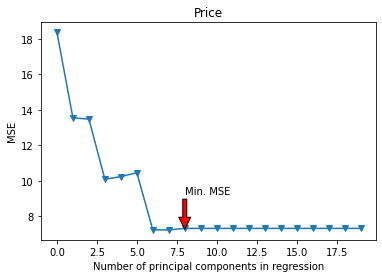

In [12]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = (
    -1
    * model_selection.cross_val_score(
        regr, np.ones((n, 1)), y.ravel(), cv=kf_10, scoring="neg_mean_squared_error"
    ).mean()
)
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = (
        -1
        * model_selection.cross_val_score(
            regr,
            X_reduced[:, :i],
            y.ravel(),
            cv=kf_10,
            scoring="neg_mean_squared_error",
        ).mean()
    )
    mse.append(score)

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(mse, "-v")
plt.xlabel("Number of principal components in regression")
plt.ylabel("MSE")
plt.title("Price")

ymin = min(mse)
xpos = mse.index(ymin)
xmin = np.arange(1, 20)[xpos]  # min 8

ax.annotate(
    "Min. MSE",
    xy=(xmin, ymin),
    xytext=(xmin, ymin + 2),
    arrowprops=dict(facecolor="red", shrink=0.02),
)

plt.xlim(xmin=-1)


In [13]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

# When M= 5 we get an 80.3%


array([23.3, 42.4, 55.4, 67.9, 80.3, 91.6, 98. , 99.9])

In [14]:

## Now let's perform PCA on the training data and evaluate its test set performance:

pca2 = PCA()
# Split into training and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.3, random_state=1
)
# Scale the data
x_reduc_train = pca2.fit_transform(scale(x_train))
n = len(x_reduc_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse2 = []

# Calculate MSE with only the intercept (no principal components in regression)
score2 = (
    -1
    * model_selection.cross_val_score(
        regr,
        np.ones((n, 1)),
        y_train.ravel(),
        cv=kf_10,
        scoring="neg_mean_squared_error",
    ).mean()
)
mse.append(score2)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score2 = (
        -1
        * model_selection.cross_val_score(
            regr,
            x_reduc_train[:, :i],
            y_train.ravel(),
            cv=kf_10,
            scoring="neg_mean_squared_error",
        ).mean()
    )
    mse2.append(score2)

(-1.0, 18.9)

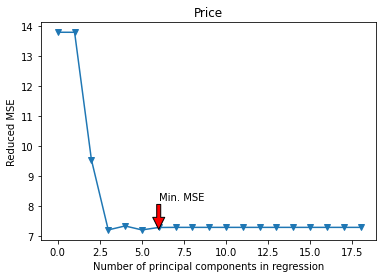

In [15]:
# Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(mse2, "-v")
plt.xlabel("Number of principal components in regression")
plt.ylabel("Reduced MSE")
plt.title("Price")

ymin = min(mse2)
xpos = mse2.index(ymin)
xmin = np.arange(1, 20)[xpos]  # min 6

ax.annotate(
    "Min. MSE",
    xy=(xmin, ymin),
    xytext=(xmin, ymin + 1),
    arrowprops=dict(facecolor="red", shrink=0.02),
)

plt.xlim(xmin=-1)

In [16]:
np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=3) * 100)

array([ 23.4,  42.5,  55.8,  68.3,  80.7,  92. ,  98.3, 100. ])

In [17]:
## We find that the lowest cross-validation error occurs when  M=6  components are used.

x_redu_test = pca2.transform(scale(x_test))[:, :5]

# Train regression model on training data
regr = LinearRegression()
regr.fit(x_reduc_train[:, :5], y_train)

# Prediction with test data
pred = regr.predict(x_redu_test)
mean_squared_error(y_test, pred)


8.909402005123031

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pcr = make_pipeline(StandardScaler(), PCA(n_components=6), LinearRegression())
pcr.fit(x_train, y_train)
pca = pcr.named_steps['pca']

In [19]:
# 6.7.2 Partial Least Squares

n = len(x_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
pls_mse = []

for i in np.arange(1, 9):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(
        pls, scale(x_train), y_train, cv=kf_10, scoring="neg_mean_squared_error"
    ).mean()
    pls_mse.append(-score)
    

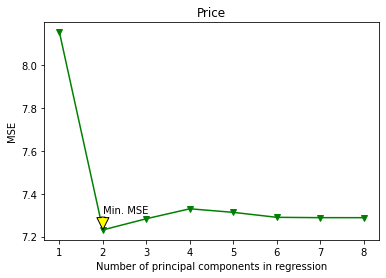

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, 9), np.array(pls_mse), "-v", color="green")
plt.xlabel("Number of principal components in regression")
plt.ylabel("MSE")
plt.title("Price")

ymin = min(pls_mse)
xpos = pls_mse.index(ymin)
xmin = np.arange(1, 9)[xpos]  # min 6

ax.annotate(
    "Min. MSE",
    xy=(xmin, ymin),
    xytext=(xmin, ymin + 0.08),
    arrowprops=dict(facecolor="yellow", shrink=0.02),
)

plt.show()

In [21]:
pls = PLSRegression(n_components=2)
pls.fit(scale(x_train), y_train)

mean_squared_error(y_test, pls.predict(scale(x_test)))

9.19707333152056

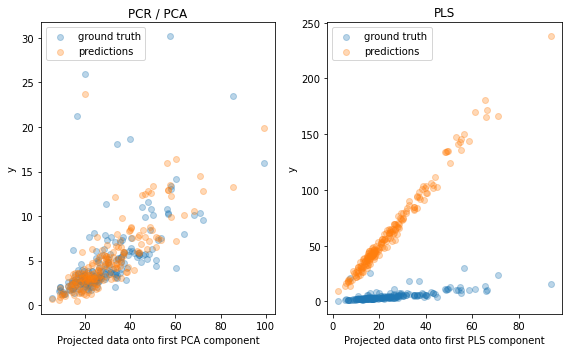

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].scatter(pca.transform(x_test)[:,0], y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(x_test)[:,0], pcr.predict(x_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend(loc='upper left')

axes[1].scatter(pls.transform(x_test)[:,0], y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(x_test)[:,0], pls.predict(x_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
plt.tight_layout()
plt.show()
